In [1]:
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial
import time

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gaussian_process import fit_2d_gp
from models.patchgpt import PatchGPT, PatchGPTConfig
from models.gpt import GPTModel, GPTModelConfig


/opt/anaconda3/envs/gpt-ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_meta = pd.read_csv('plasticc/plasticc_train_metadata.csv.gz')
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
tokenizer = LCTokenizer(-10000, 10000, 500, 1000, 500, bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=1)

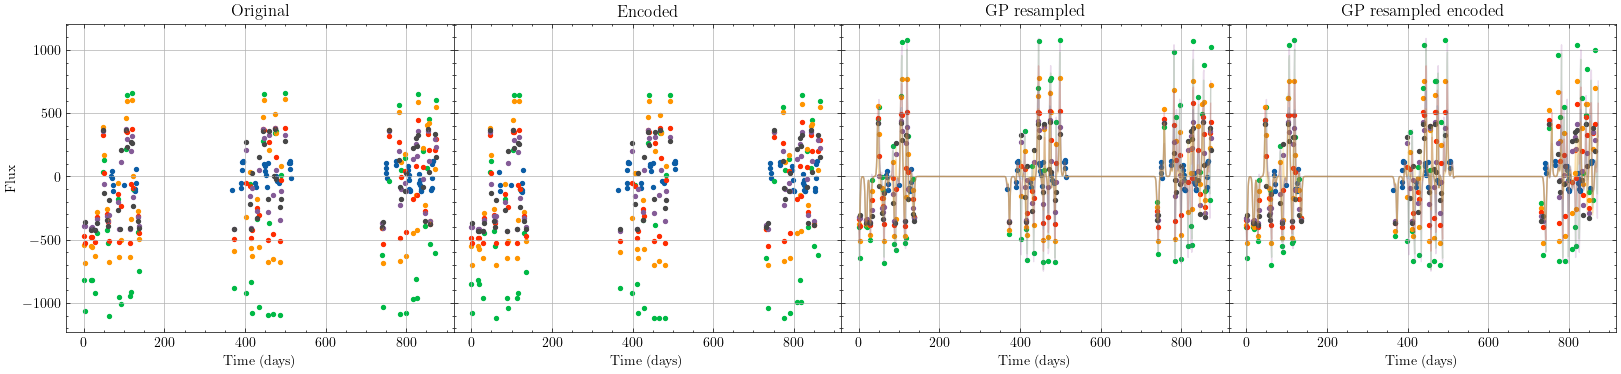

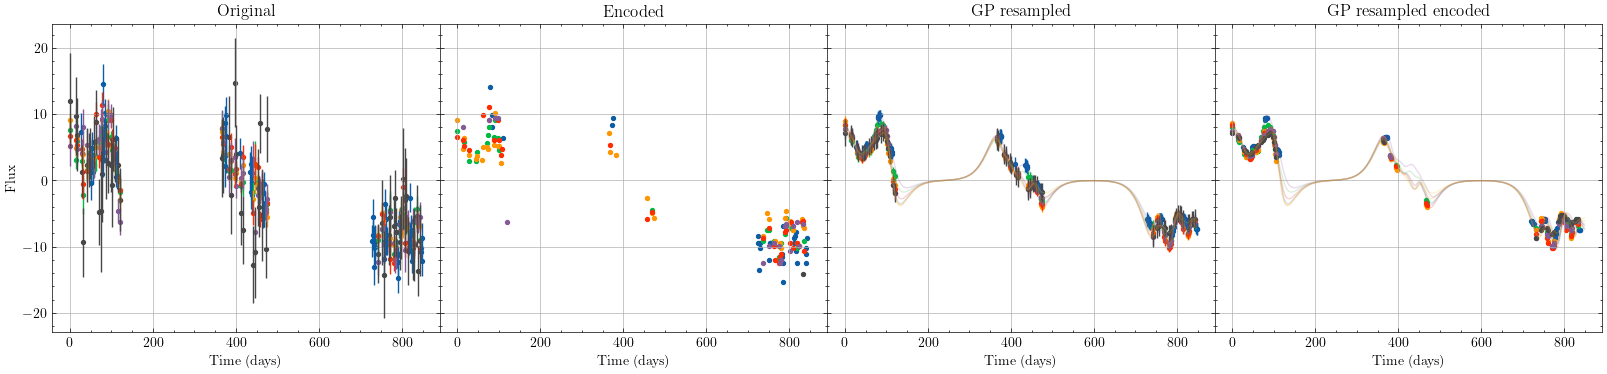

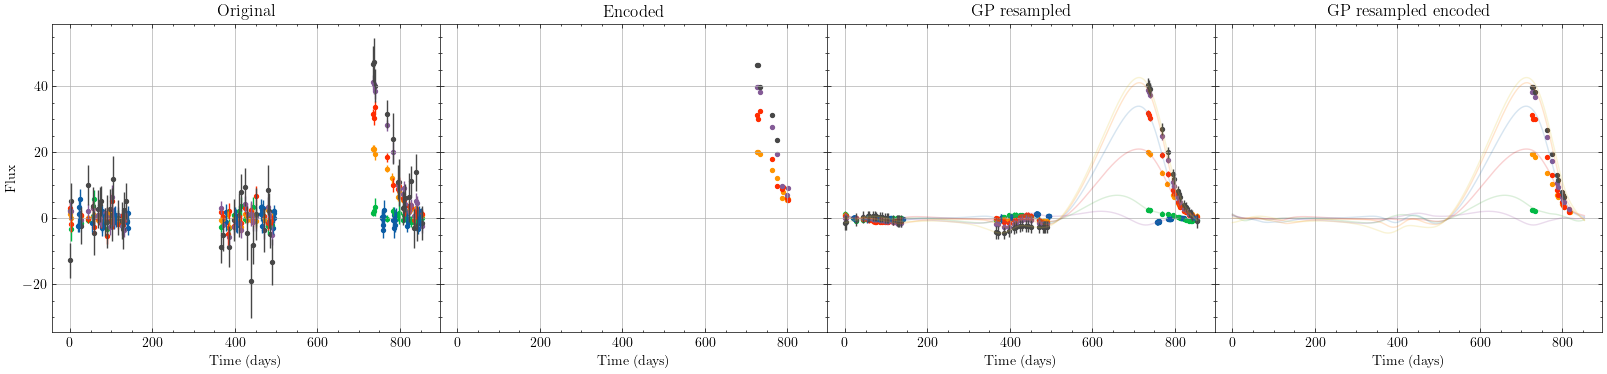

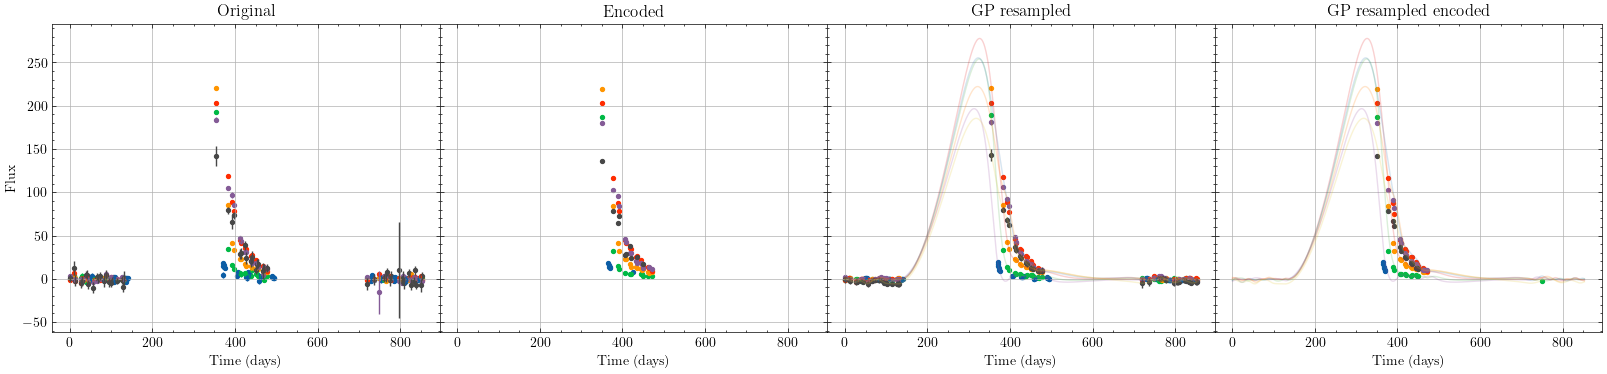

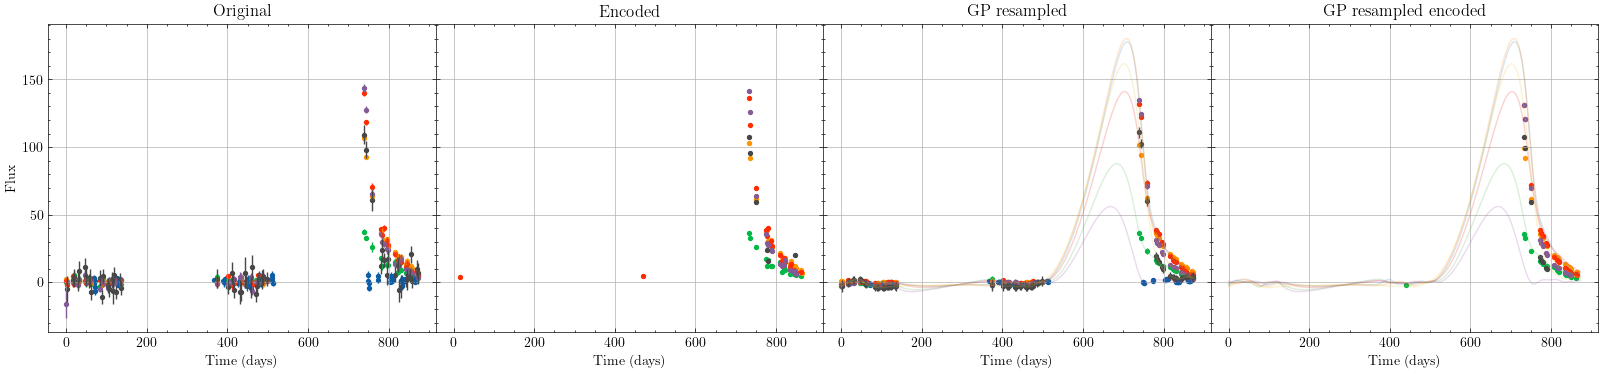

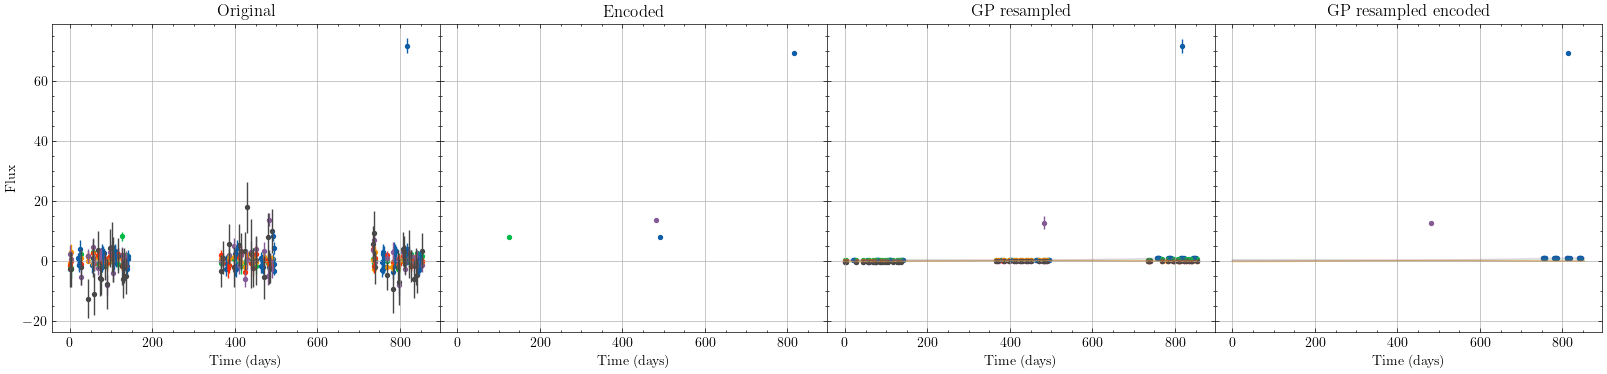

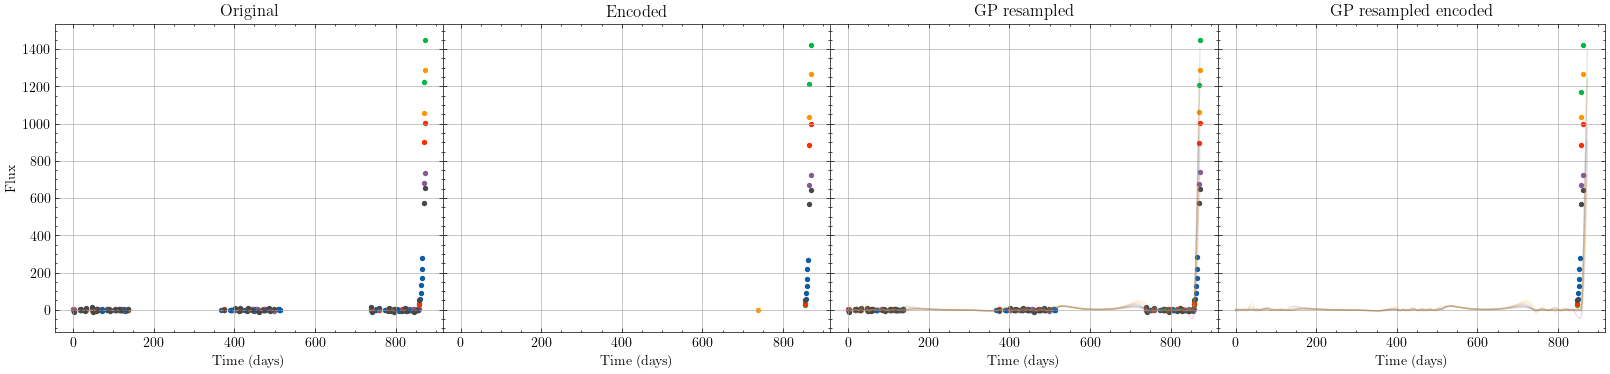

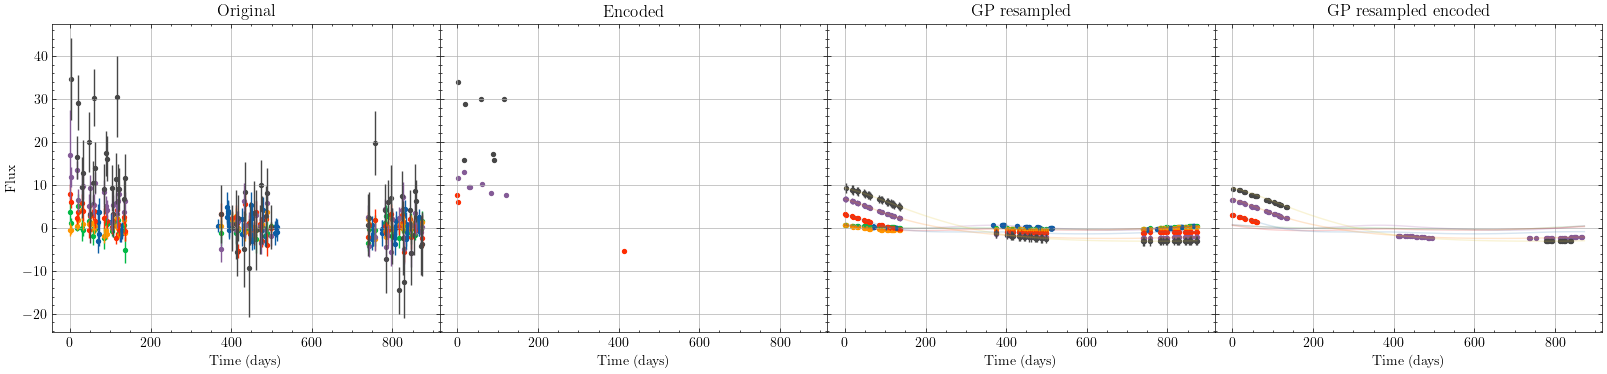

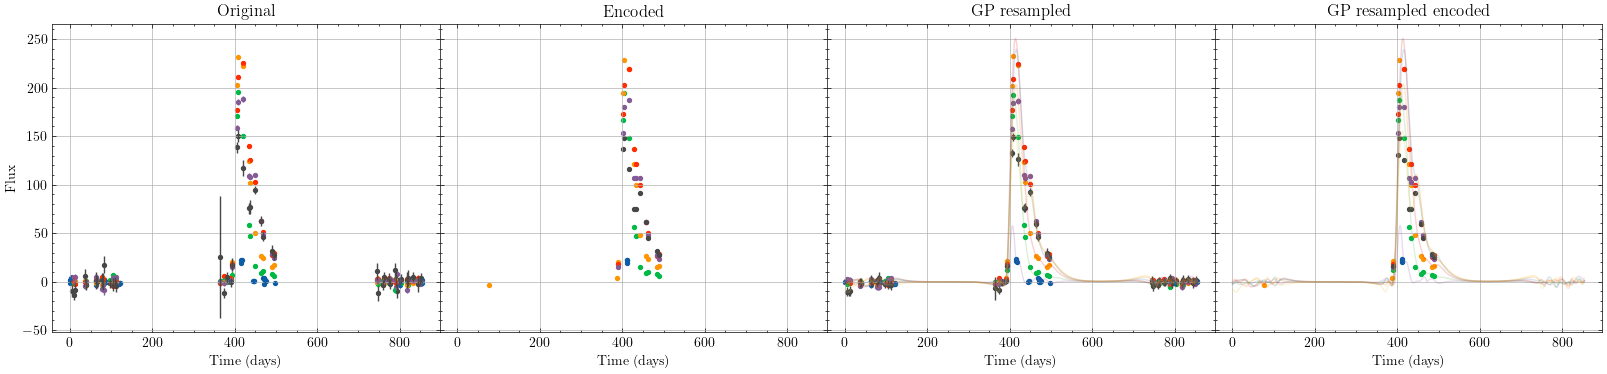

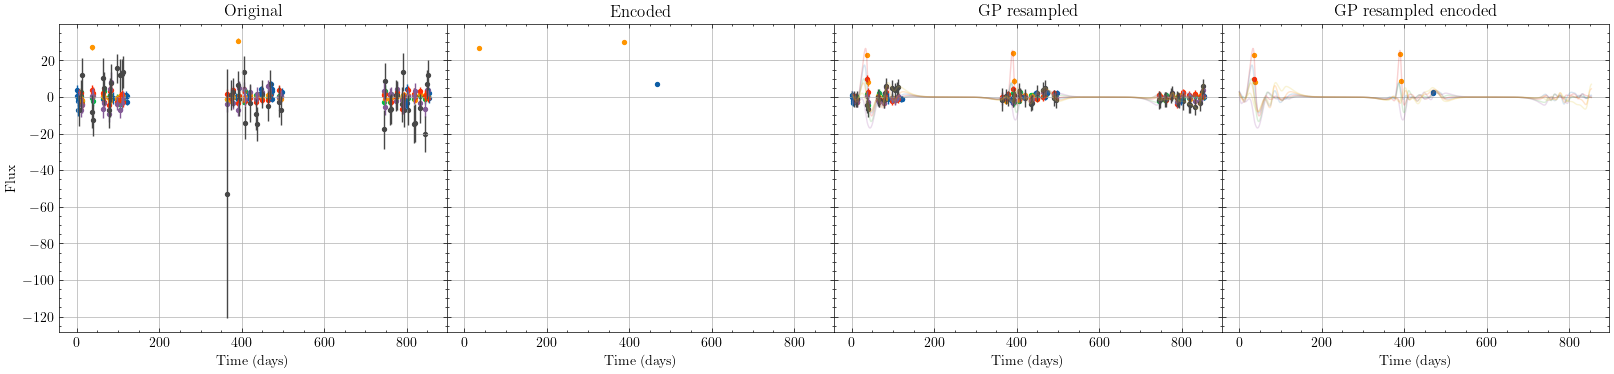

In [4]:
for i, row in df_meta.head(10).iterrows():
    df_object = df.loc[(df["object_id"] == row["object_id"]), :]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask), success = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    tokens = tokenizer.encode(df_object)
    resampled_tokens = tokenizer.encode(resampled_df)
    axes = plot_lightcurve([df_object, tokenizer.decode(tokens), resampled_df, tokenizer.decode(resampled_tokens)], 
                           titles=['Original', 'Encoded', 'GP resampled', 'GP resampled encoded'])
    for i in range(6):
        axes[2].plot(sampled_times, sampled_obs[i,:], color=config['pb_colors'][i], alpha=0.2)
        axes[3].plot(sampled_times, sampled_obs[i,:], color=config['pb_colors'][i], alpha=0.2)

# Pre-trained GPT

In [6]:
gpt = GPTModel.from_pretrained('adammoss/gpt-pretrain-lm-w1')

In [7]:
gpt.config

GPTModelConfig {
  "_name_or_path": "adammoss/gpt-pretrain-lm-w1",
  "architectures": [
    "GPTModel"
  ],
  "dropout": 0.1,
  "head_type": "lm",
  "is_causal": true,
  "model_type": "gptmodel",
  "n_embd": 384,
  "n_head": 6,
  "n_labels": 18,
  "n_layer": 6,
  "n_positions": 1024,
  "n_static": 2,
  "position_embedding": "relative_key",
  "torch_dtype": "float32",
  "transformers_version": "4.39.2",
  "vocab_size": 3501
}

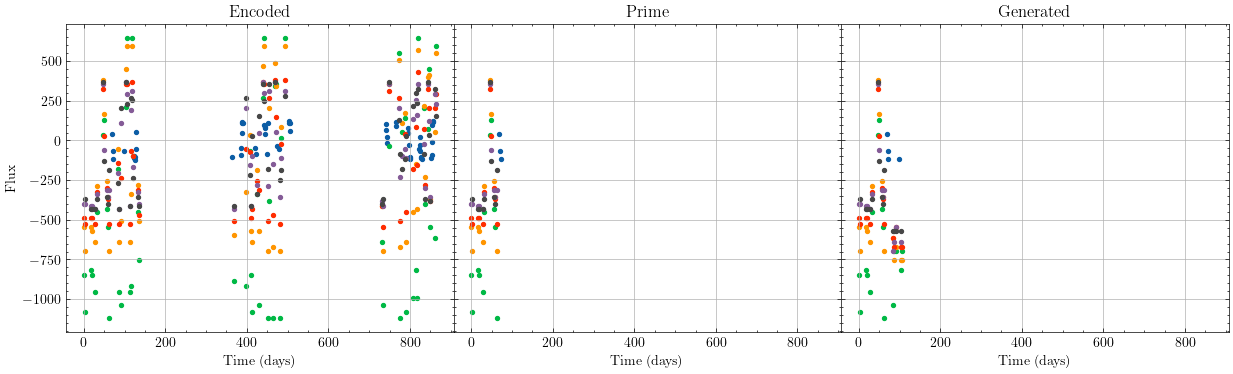

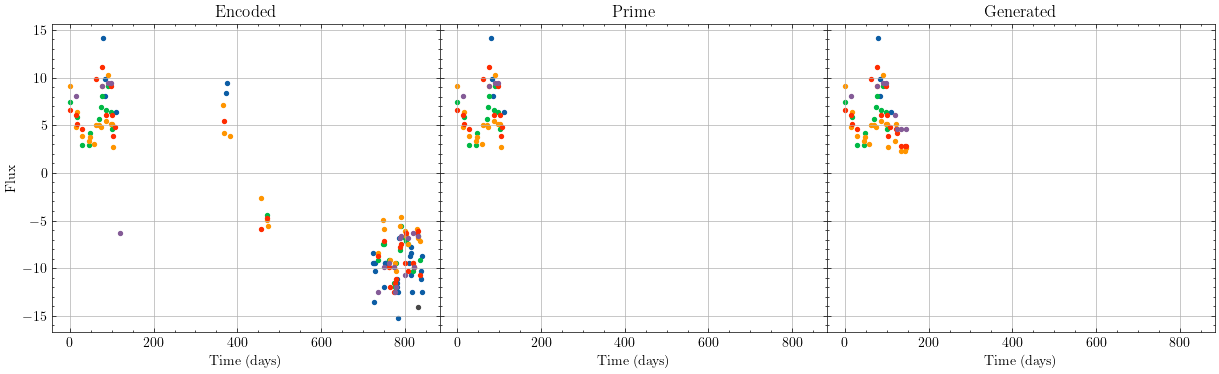

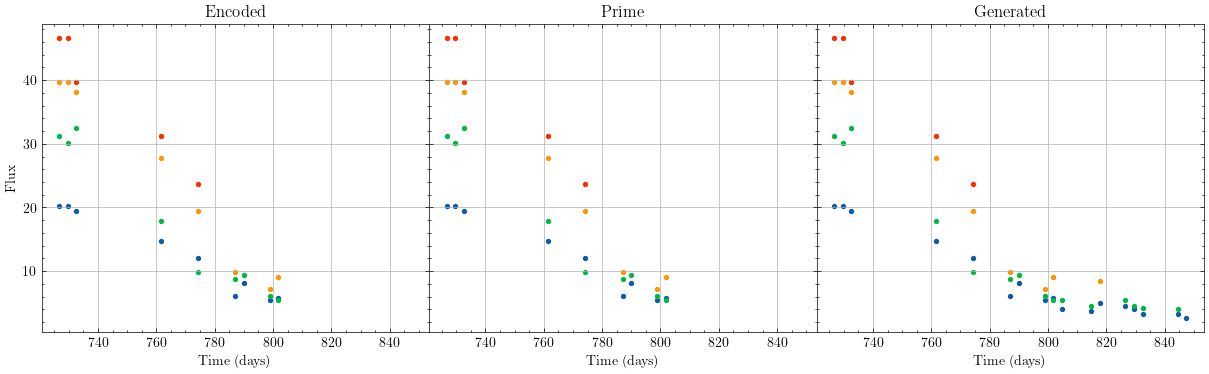

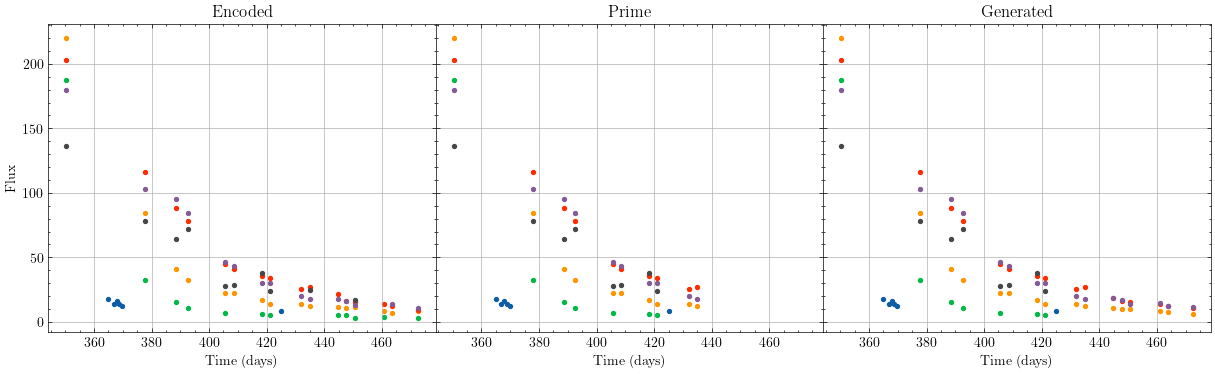

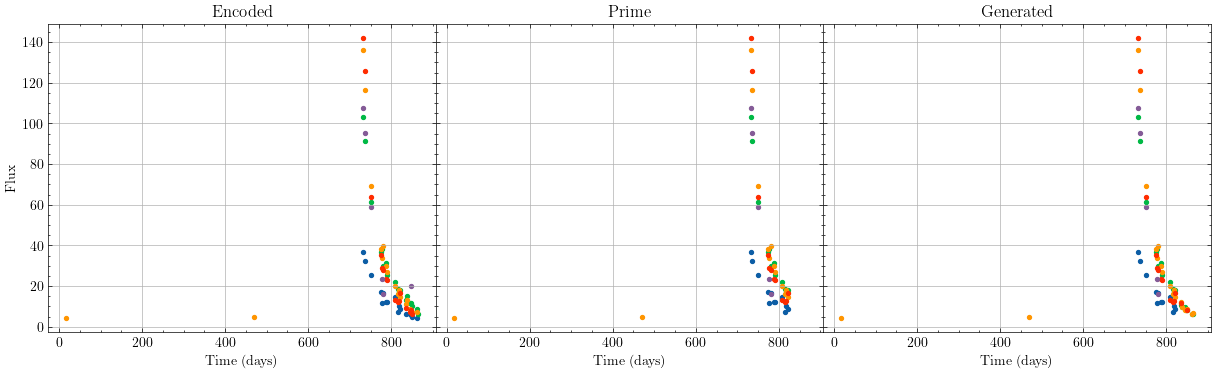

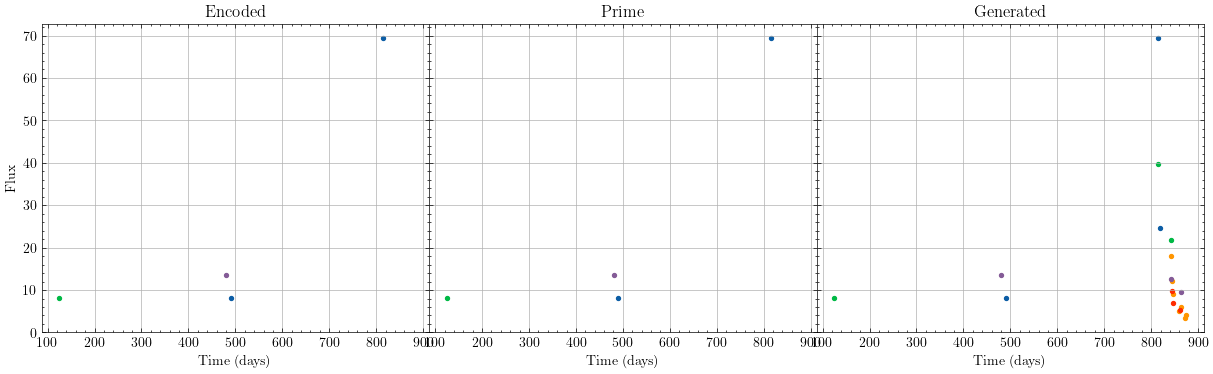

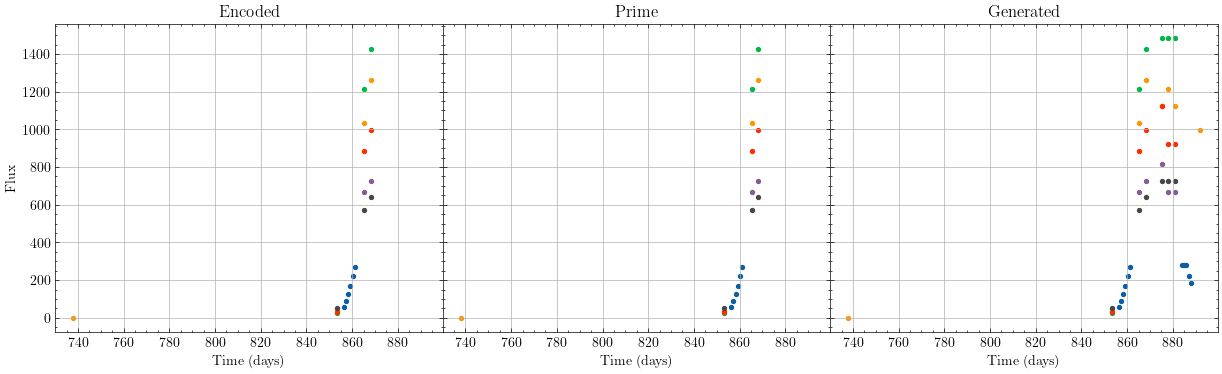

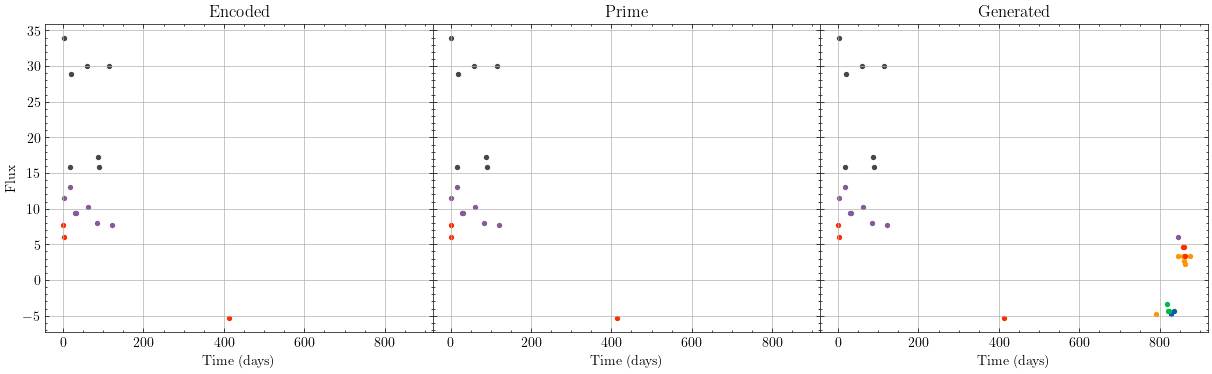

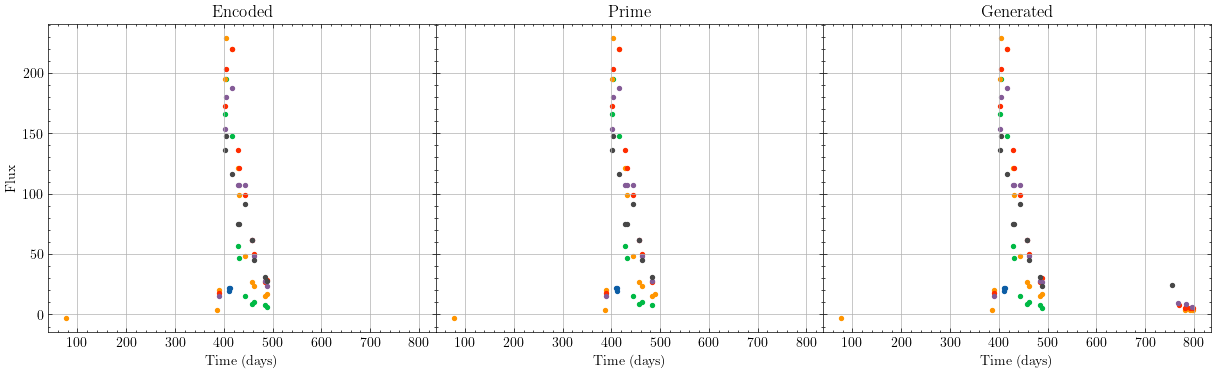

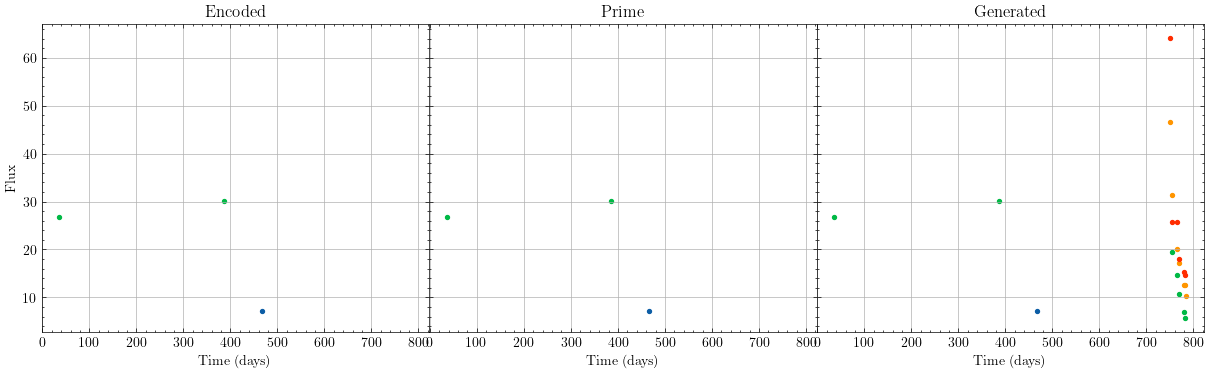

In [11]:
for i, row in df_meta.head(10).iterrows():
    static = torch.tensor([[row['hostgal_photoz'], row['hostgal_photoz_err']]], dtype=torch.float32) 
    df_object = df.loc[(df["object_id"] == row["object_id"]), :]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    tokens = tokenizer.encode(df_object)
    prime = torch.tensor([tokens[0:70]], dtype=torch.long)
    generated = gpt.generate(prime, 30, static=static, temperature=0.1)
    axes = plot_lightcurve([tokenizer.decode(tokens), tokenizer.decode(prime[0].numpy()), tokenizer.decode(generated[0].numpy())], 
                           titles=['Encoded', 'Prime', 'Generated'])

# Pre-trained GPT with GP

In [12]:
gpt_gp = GPTModel.from_pretrained('adammoss/gpt-pretrain-lm-gp')

In [13]:
gpt_gp.config

GPTModelConfig {
  "_name_or_path": "adammoss/gpt-pretrain-lm-gp",
  "architectures": [
    "GPTModel"
  ],
  "dropout": 0.1,
  "head_type": "lm",
  "is_causal": true,
  "model_type": "gptmodel",
  "n_embd": 384,
  "n_head": 6,
  "n_labels": 18,
  "n_layer": 6,
  "n_positions": 1024,
  "n_static": 2,
  "position_embedding": "relative_key",
  "torch_dtype": "float32",
  "transformers_version": "4.39.2",
  "vocab_size": 3501
}

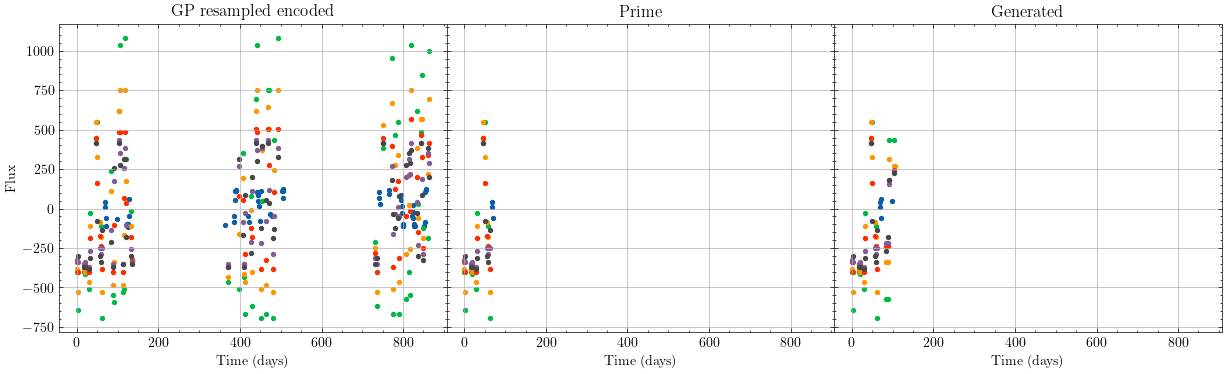

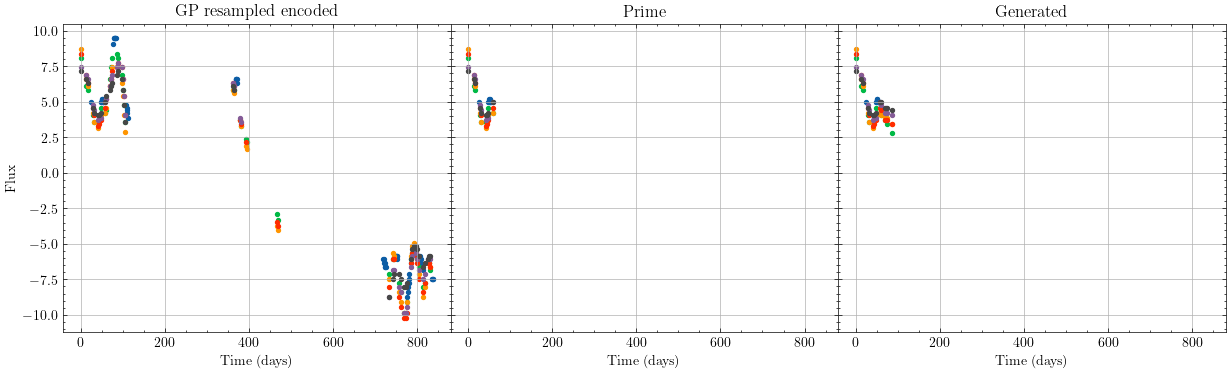

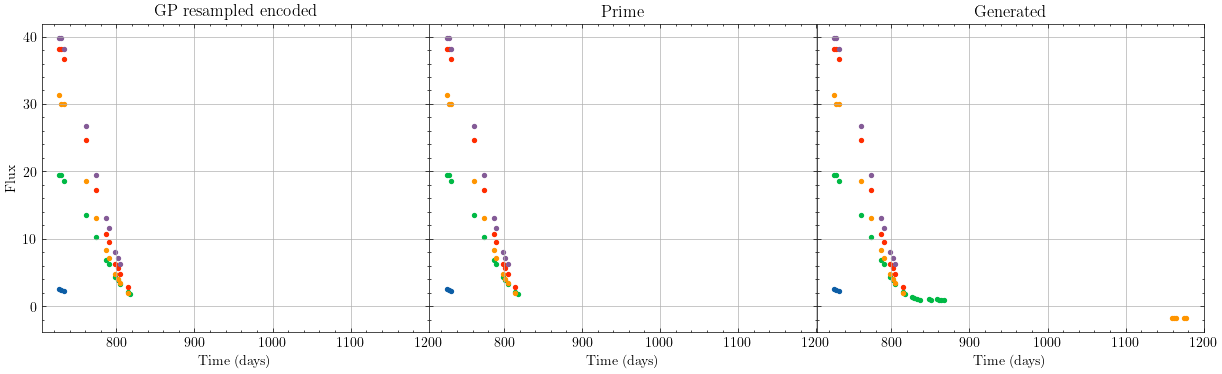

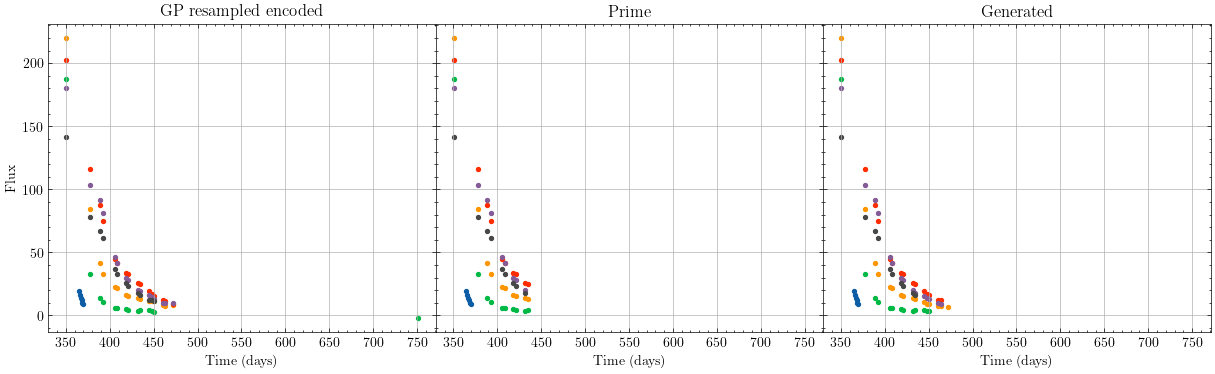

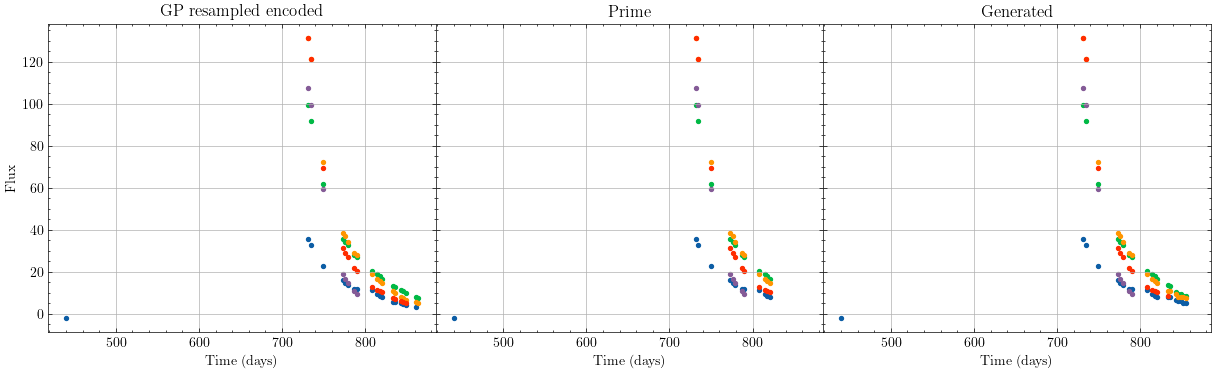

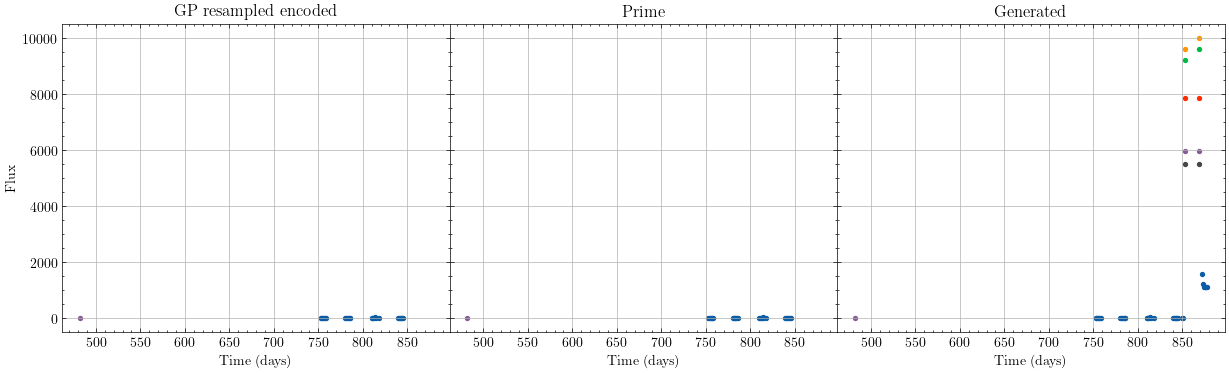

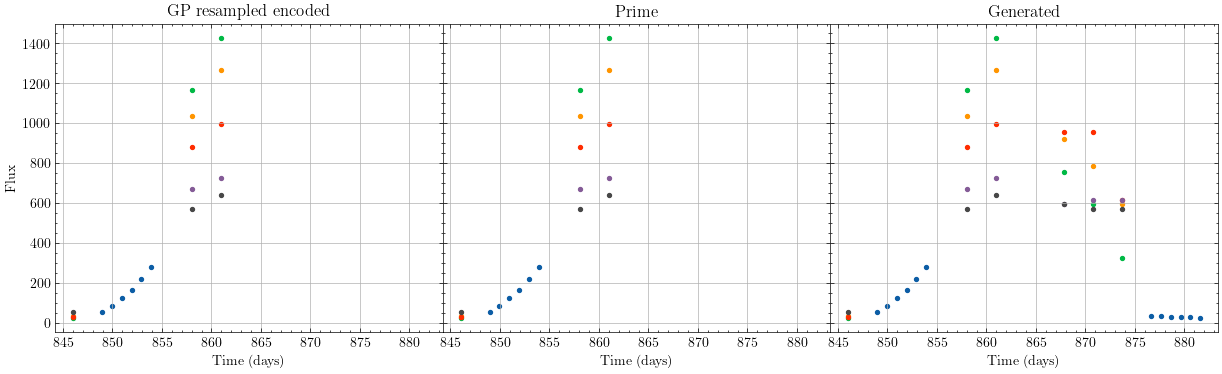

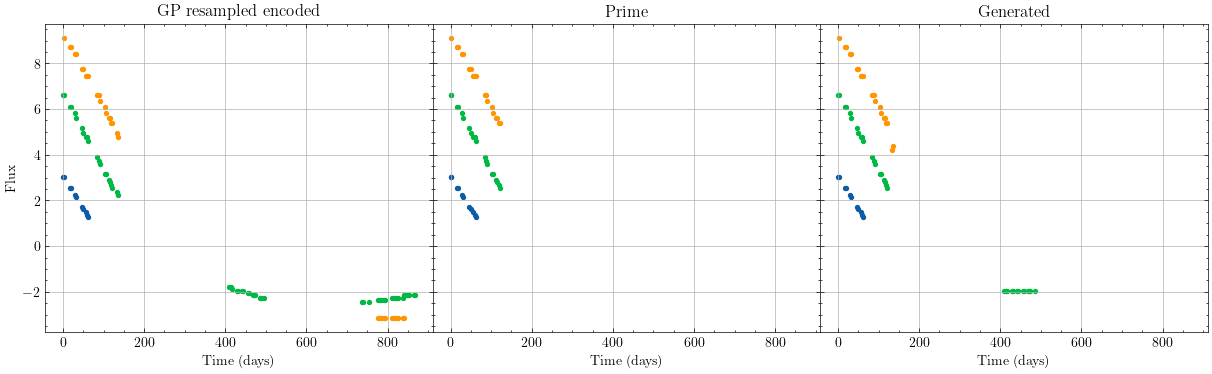

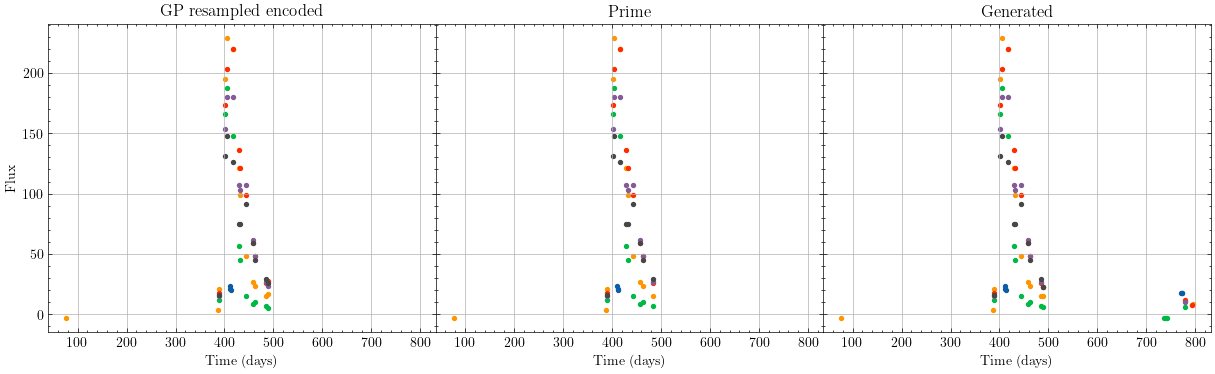

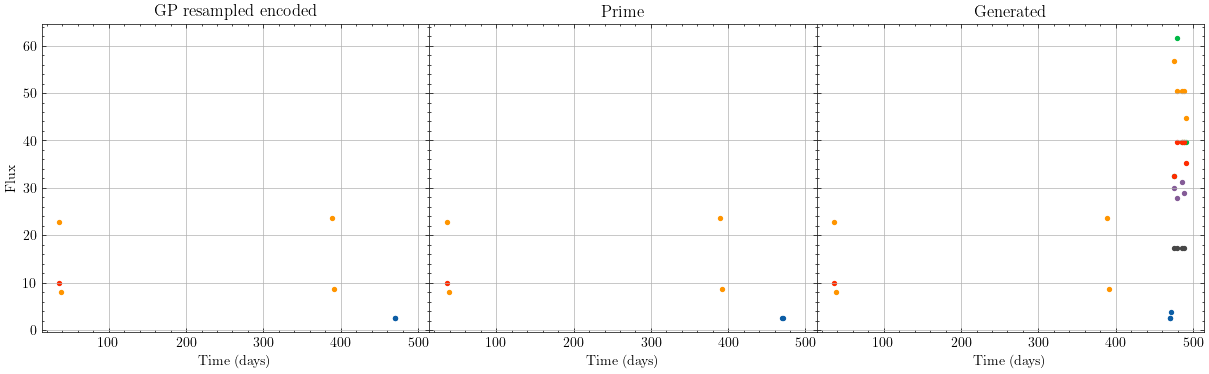

In [19]:
for i, row in df_meta.head(10).iterrows():
    df_object = df.loc[(df["object_id"] == row["object_id"]), :]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    resampled_df, _, success = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=None)
    tokens = tokenizer.encode(df_object)
    resampled_tokens = tokenizer.encode(resampled_df)
    prime = torch.tensor([resampled_tokens[0:70]], dtype=torch.long)
    generated = gpt_gp.generate(prime, 30, static=static, temperature=0.1)
    axes = plot_lightcurve([tokenizer.decode(resampled_tokens), tokenizer.decode(prime[0].numpy()), 
                            tokenizer.decode(generated[0].numpy())], titles=['GP resampled encoded', 'Prime', 'Generated'])

# Pre-trained Patch GPT 

In [ ]:
patchgpt = PatchGPT.from_pretrained('adammoss/patch-pretrain-mask-6')
patchify.eval()

In [ ]:
patchgpt.config

In [ ]:
patch_size = 50

In [ ]:
for i, row in df_meta.head(1).iterrows():
    df_object = df.loc[(df["object_id"] == row["object_id"]), :]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask), success = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    tokens = tokenizer.encode(df_object)
    resampled_tokens = tokenizer.encode(resampled_df)
    axes = plot_lightcurve([df_object, tokenizer.decode(tokens), resampled_df, tokenizer.decode(resampled_tokens)])
    for i in range(6):
        axes[2].plot(sampled_times, sampled_obs[i,:], color=config['pb_colors'][i], alpha=0.2)
        axes[3].plot(sampled_times, sampled_obs[i,:], color=config['pb_colors'][i], alpha=0.2)
    plt.show()
    for i in range(3):
        fig, axes = plt.subplots(1,2, figsize=(6,3))
        axes[0].imshow(sampled_obs[:,i*patch_size:(i+1)*patch_size])
        axes[1].imshow(sampled_mask[:,i*patch_size:(i+1)*patch_size])
        plt.show()

In [ ]:
patchify.random_mask_ratio = 0.0

In [ ]:
x = torch.tensor(np.expand_dims(np.arcsinh(sampled_obs), 0), dtype=torch.float32).transpose(1, 2)
mask = torch.tensor(np.expand_dims(sampled_mask, 0), dtype=torch.int32).transpose(1, 2)

In [ ]:
output = patchify(x, attention_mask=mask)

In [ ]:
output.loss

In [ ]:
for i in range(6):
    plt.plot(sampled_times, np.sinh(output.x_pred.detach().numpy()[0,0:sampled_times.shape[0],i]), color=config['pb_colors'][i])
    plt.plot(sampled_times, (sampled_obs[i,:]), color=config['pb_colors'][i], linestyle='--')
    plt.show()

In [ ]:
plt.plot(output.mask.cpu().numpy()[0])